# Generating images with AI

This notebook demonstrates how to use OpenAI DALL-E 2 to generate images, in combination with other LLM features like text and embedding generation.

Here, we use Text Generation to generate a random image description and DALL-E 2 to create an image from that description, showing the image inline.

Lastly, the notebook asks the user to describe the image. The embedding of the user's description is compared to the original description, using Cosine Similarity, and returning a score from 0 to 1, where 1 means exact match.

In [ ]:
// Usual setup: importing Semantic Kernel SDK and SkiaSharp, used to display images inline.

#r "nuget: Microsoft.SemanticKernel, 0.18.230725.3-preview"
#r "nuget: SkiaSharp, 2.88.3"

#!import config/Settings.cs
#!import config/Utils.cs
#!import config/SkiaUtils.cs

using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.AI.ImageGeneration; 
using Microsoft.SemanticKernel.AI.Embeddings;
using Microsoft.SemanticKernel.AI.Embeddings.VectorOperations;

# Setup, using three AI services: images, text, embedding

The notebook uses:

* **text-davinci-003** to generate a random image description
* **OpenAI Dall-E 2** to transform the image description into an image
* **text-embedding-ada-002** to compare your guess against the real image description

In [ ]:
// Load OpenAI credentials from config/settings.json
var (useAzureOpenAI, model, azureEndpoint, apiKey, orgId) = Settings.LoadFromFile();

// Configure the three AI features: text embedding (using Ada), text completion (using DaVinci 3), image generation (DALL-E 2)
var builder = new KernelBuilder();

if(useAzureOpenAI)
{
    builder.WithAzureTextEmbeddingGenerationService("text-embedding-ada-002", azureEndpoint, apiKey);
    builder.WithAzureTextCompletionService("text-davinci-003", azureEndpoint, apiKey);
    builder.WithAzureOpenAIImageGenerationService(azureEndpoint, apiKey);
}
else
{
    builder.WithOpenAITextEmbeddingGenerationService("text-embedding-ada-002", orgId);
    builder.WithOpenAITextCompletionService("text-davinci-003", orgId);
    builder.WithOpenAIImageGenerationService(apiKey, orgId);
}
   
var kernel = builder.Build();

// Get AI service instance used to generate images
var dallE = kernel.GetService<IImageGeneration>();

// Get AI service instance used to extract embedding from a text
var textEmbedding = kernel.GetService<ITextEmbeddingGeneration>();

# Generate a (random) image with DALL-E 2

**genImgDescription** is a Semantic Function used to generate a random image description. 
The function takes in input a random number to increase the diversity of its output.

The random image description is then given to **Dall-E 2** asking to create an image.


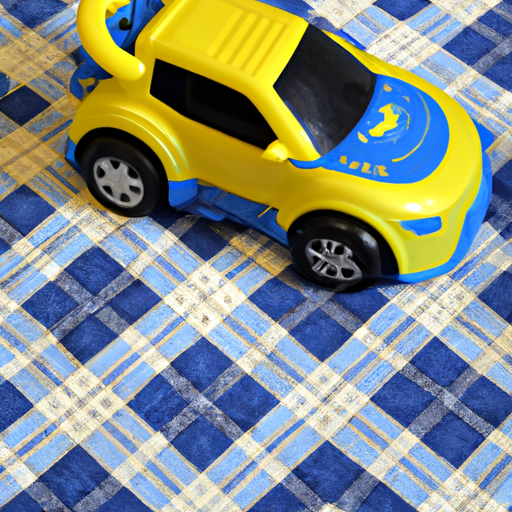

In [ ]:
// Create a semantic function that generate a random image description.
var genImgDescription = kernel.CreateSemanticFunction(
    "Think about an artificial object correlated to number {{$input}}. " +
    "Describe the image with one detailed sentence. The description cannot contain numbers.", 
    maxTokens: 256, temperature: 1);

var random = new Random().Next(0, 200);
var imageDescription = await genImgDescription.InvokeAsync($"{random}");

// Use DALL-E 2 to generate an image. OpenAI in this case returns a URL (though you can ask to return a base64 image)
var imageUrl = await dallE.GenerateImageAsync(imageDescription.Result.Trim(), 512, 512);

await SkiaUtils.ShowImage(imageUrl, 512, 512);

# Let's play a guessing game

Try to guess what the image is about, describing the content.

You'll get a score at the end 😉

In [ ]:
// Prompt the user to guess what the image is
var guess = await InteractiveKernel.GetInputAsync("Describe the image in your words");

// Compare user guess with real description and calculate score
var origEmbedding = await textEmbedding.GenerateEmbeddingsAsync(new List<string> { imageDescription.Result} );
var guessEmbedding = await textEmbedding.GenerateEmbeddingsAsync(new List<string> { guess } );
var similarity = origEmbedding.First().AsReadOnlySpan().CosineSimilarity(guessEmbedding.First().AsReadOnlySpan());

Console.WriteLine($"Your description:\n{Utils.WordWrap(guess, 90)}\n");
Console.WriteLine($"Real description:\n{Utils.WordWrap(imageDescription.Result.Trim(), 90)}\n");
Console.WriteLine($"Score: {similarity:0.00}\n\n");

//Uncomment this line to see the URL provided by OpenAI
//Console.WriteLine(imageUrl);

Your description:
a blue and yellow toy ca over a squared blue and yellow surface


Real description:
A bright yellow plastic toy car with a blue stripe down the side and a white star on the
hood, sitting atop a checkered patterned rug.


Score: 0.92


